# Background

The experiments record the trajectories (a series of x,y,z coordinates, with associated amplitude of each point) of products resulting from collision/reaction between Mg22 and alpha particles in ATTPC.

# User-Desired Settings

The isotope used in this experiment is Mg22.

In [ ]:
ISOTOPE = 'Mg22'

For each point, high amplitude (of voltage?) suggests high quality, whereas low amplitude suggests the detection may result from noise. We set the lowest amplitude for the point to be incorporated into our analysis as 50.

In [ ]:
amp_threshold = 50

The neural network model requires a fixed number of inputs. Whereas the actual events comprise different number of points, we will select exactly 512 points (may be redundant) as final inputs of each event.

In [ ]:
sample_size = 256

We create a folder named "test" to store the outputs.

In [11]:
dir_name = '256c/'

# Data Processing

## Import Libraries

In [1]:
import h5py
import numpy as np
import tqdm
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from mpl_toolkits import mplot3d

## Import Data
This file comprises 4330 events. \
Each event comprises 353-1852 points. \
Each point has 12 entries: x[0], y[1], z[2], time[3], amplitude[4], particleID[5], pointID[6], energy[7] ,energy loss[8], angle[9], mass[10], atomic number[11]. \
The only meaningful entries are x[0], y[1], z[2], amplitude[4].

In [4]:
# path = dir_name + '/data/output.h5'
file = h5py.File('../simulated/Mg22_alpha.h5', 'r')
event_ids = list(file.keys())

Make a 1d array of event lengths (number of points in each event).

In [12]:
num_of_event = len(event_ids) # 4330
ev_lens = np.zeros(num_of_event, int)
for i in range(num_of_event):
    event_id = event_ids[i]
    event = file[event_id]
    ev_lens[i] = len(file[event_id])

evlen_path = dir_name + ISOTOPE + '_exp_A0_ev_lens'
np.save(evlen_path, ev_lens)

Make a 3d array of data.\
axis 0 (size 4330): events \
axis 1 (size 1852): points within each event\
axis 2 (size 6): x[0], y[1], z[2], amplitude[3], pointId[4], eventId[5] of each point

In [13]:
max_ev_len = np.max(ev_lens)  # 1852
data = np.zeros((num_of_event, max_ev_len, 6), float) 
for n in tqdm.tqdm(range(num_of_event)):
    event_id = event_ids[n]
    event = file[event_id]
    #converting event into an array
    for i,e in enumerate(event):
        instant = np.array(list(e))
        data[n][i][0:3] = np.array(instant[0:3]) # x,y,z
        data[n][i][3] = np.array(instant[4]) # amplitude
        data[n][i][4] = np.arange(1,max_ev_len+1)[i] # pointID --coded from 1 to 1852
        data[n][i][5] = float(n) # eventID

data_path = dir_name + ISOTOPE + '_exp_A0_XYZAPE'  
np.save(data_path, data)

100%|██████████| 10000/10000 [04:18<00:00, 38.67it/s]


When running this notebook the second time, simply reload the data (instead of spending 10 min to repeat the step above).

In [14]:
evlen_path = dir_name + ISOTOPE + '_exp_A0_ev_lens.npy'
data_path = dir_name + ISOTOPE + '_exp_A0_XYZAPE.npy'
ev_lens = np.load(evlen_path)
data = np.load(data_path)
num_of_event = len(data)
max_ev_len = len(data[0])

In [15]:
null_ind = np.zeros(num_of_event, int)
nullInd_path = dir_name + ISOTOPE + '_exp_nullInd'
np.save(nullInd_path, null_ind)

### Plot distributions

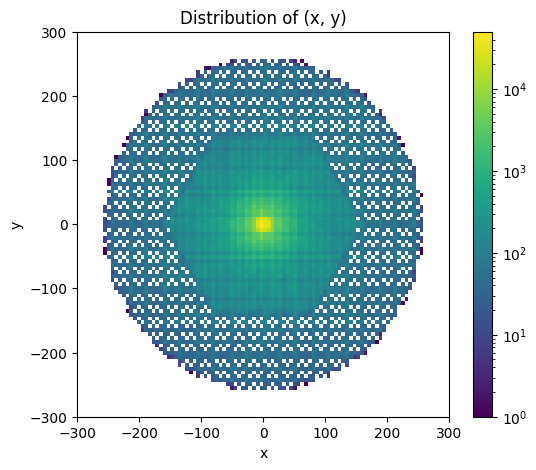

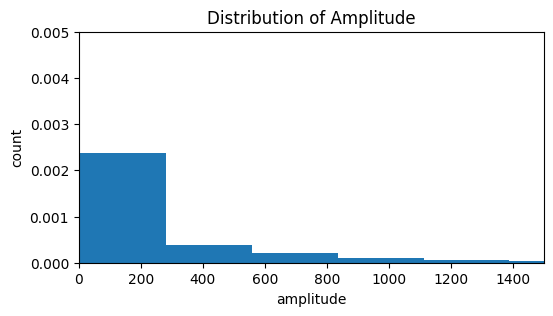

In [16]:
count = 0
for i in range(num_of_event):
    count = count + ev_lens[i]
    
x_data = np.zeros(count, float)
y_data = np.zeros(count, float)
a_data = np.zeros(count, float)
count = 0
for i in range(num_of_event):
    for j in range(ev_lens[i]):
        x_data[count] = data[i][j][0]
        y_data[count] = data[i][j][1]
        a_data[count] = data[i][j][3]
        count += 1

plt.figure(figsize=(6, 5))
plt.hist2d(x_data, y_data, bins=(100,100), range=[[-300, 300], [-300, 300]], norm=LogNorm())
plt.xlabel('x')
plt.ylabel('y')
# plt.ylim([-20, 150])
# plt.xlim([-150, 20])
plt.title('Distribution of (x, y)')
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 3))
plt.hist(a_data, density=True, bins=100)
plt.ylabel('count')
plt.xlabel('amplitude')
plt.ylim([0, 0.005])
plt.xlim([0, 1500])
plt.title('Distribution of Amplitude')
plt.show()

### Plot Events

This plotting function is used for four datasets in this notebook: \
mode = 0: raw data\
mode = 1: null vs no-null data\
mode = 2: no-null data

In [17]:
palette = ['k', 'c']
def plot_events(evlen_path, data_path, nullInd_path, amp_threshold, mode, rows):
    ev_lens = np.load(evlen_path)
    data =  np.load(data_path) 
    null_inds = np.load(nullInd_path)
    
    fig = plt.figure(figsize=(17,rows*4))
    
    for n in range(rows*5):
        ax = fig.add_subplot(rows, 5, n+1, projection='3d')
        ev_len = ev_lens[n]
        evt = data[n,:ev_len,:]

        pt_count = 0
        wedge_pt_count = 0
        
        for i,e in enumerate(evt):
            x = e[0] #get x value of point
            y = e[1] #get y value of point
            z = e[2] #get z value of point
            a = e[3] #get amplitude of point
            if mode == 0:
                if a >= amp_threshold:
                    color = palette[0]
                    pt_count += 1
                    if (-130 < x < 10 and -10 < y < 130 and (-x/3) < y < (-3*x)):
                        wedge_pt_count += 1
                else:
                    color = palette[1]
            else:
                color = palette[0]
            ax.scatter3D(x,y,z, color = color, s = 1)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
            
        if mode == 0:
            high_amp = patches.Patch(color=palette[0], label = 'A>='+str(amp_threshold))
            low_amp = patches.Patch(color=palette[1], label = 'A<'+str(amp_threshold))
            plt.legend(handles=[high_amp, low_amp], fontsize='small')
            plt.title('Event {} \n'.format(n) + str(wedge_pt_count) + ' / ' + str(pt_count) + ' / ' + str(ev_len) + ' points')
        elif mode == 1:
            if (null_inds[n] == 1):
                plt.title('Event {} \n'.format(n) + 'Null')
            else:
                plt.title('Event {} \n'.format(n) + str(ev_len) + ' points')
        elif mode == 2 or mode == 4:
            plt.title('Event {} \n'.format(int(data[n,0,5])) + str(ev_len) + ' points')
            
        n += 1

The subplots below display the raw xyz data. (mode = 0.)\
The three numbers are (1) the number of points with amplitudes higher than the user-desired threshold; (2) the number of points detected in the "wedge" region; (3) the total number of poitns.

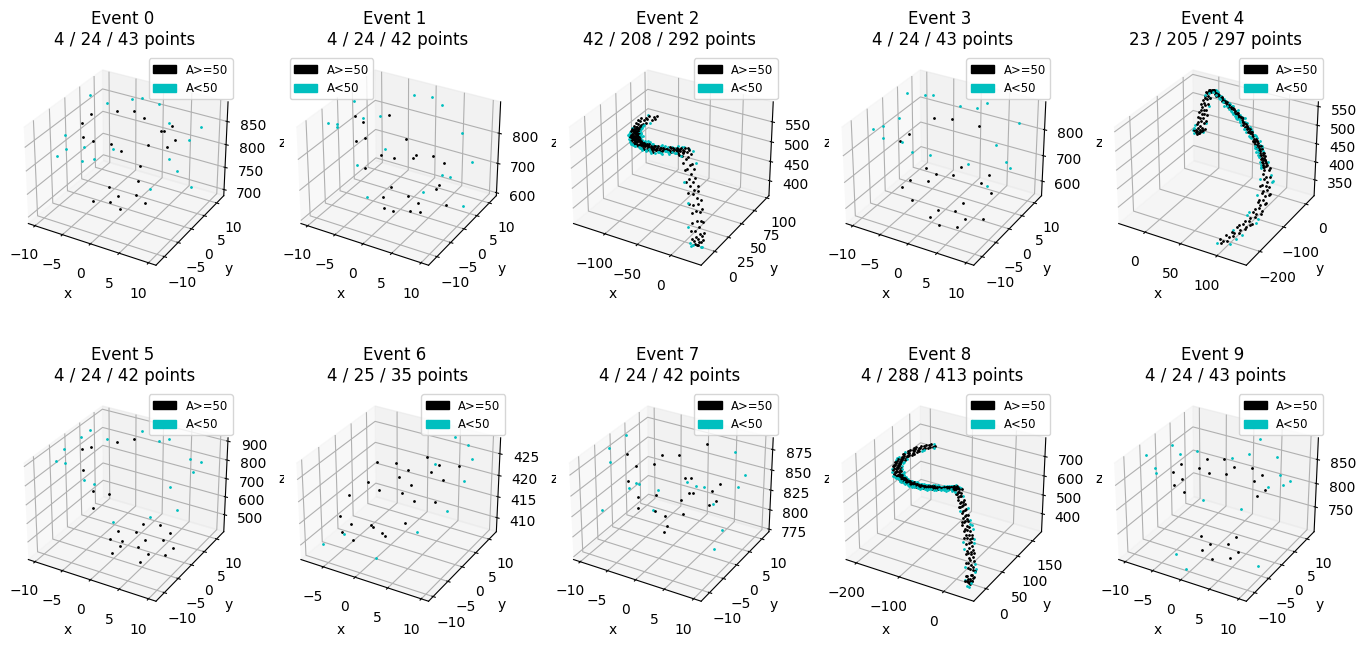

In [18]:
evlen_path = dir_name + ISOTOPE + '_exp_A0_ev_lens.npy'
data_path = dir_name + ISOTOPE + '_exp_A0_XYZAPE.npy'
nullInd_path = dir_name + ISOTOPE + '_exp_nullInd.npy'
plot_events(evlen_path, data_path, nullInd_path, amp_threshold, 0, 2)

## Remove Low-Amp Points; Remove Null Events
Notice that there are three types of events: \
(1) Events with no visible patterns. \
    E.g., 0, 1, 2, 6, 8, 9, 13, 17, 20, 21, 22, 28, 30, 31, 32, 35, 36, 37, 40, 41, 43, 47, 48, 49 \
(2) Events with a wedge-like shape. (Per Yassid, this shape is caused by detection bias.) \
    E.g., 3, 7, 10, 12, 15, 19, 23, 29, 33, 34, 38, 45, 46 \
(3) Events with trajectories. \
    E.g., 4, 5, 11, 14, 16, 18, 24, 25, 26, 27, 39, 42, 44

We only want to keep type (3). To do so, we first filter the points of low amplitude from all events.

In [19]:
evlen_path = dir_name + ISOTOPE + '_exp_A0_ev_lens.npy'
data_path = dir_name + ISOTOPE + '_exp_A0_XYZAPE.npy'
ev_lens = np.load(evlen_path)
data = np.load(data_path)
num_of_event = len(data)
max_ev_len = len(data[0])
data_filter = np.zeros((num_of_event, max_ev_len, 6), float) 
ev_len_filter = np.zeros(num_of_event, int)

for n in tqdm.tqdm(range(num_of_event)):
    count = 0
    for i in range(ev_lens[n]):
        if (data[n,i,3] < amp_threshold):
            continue
        else:
            data_filter[n,count] = data[n,i]
            count += 1
    ev_len_filter[n] = count
    
max_ev_len = np.max(ev_len_filter)
data_filter_saving = data_filter[:,:np.max(ev_len_filter),:]

evlen_path = dir_name + ISOTOPE + '_exp_A' + str(amp_threshold) + '_ev_lens'
data_path = dir_name + ISOTOPE + '_exp_A'+ str(amp_threshold) + '_XYZAPE'
np.save(evlen_path, ev_len_filter)
np.save(data_path, data_filter_saving)

100%|██████████| 10000/10000 [00:01<00:00, 8461.82it/s]


Then we mark the events with \
(1) few total points, or \
(2) numerous points in the area where the wedge-like shape often occurs \
as null.

In [20]:
evlen_path = dir_name + ISOTOPE + '_exp_A' + str(amp_threshold) + '_ev_lens.npy'
data_path = dir_name + ISOTOPE + '_exp_A'+ str(amp_threshold) + '_XYZAPE.npy'
nullInd_path = dir_name + ISOTOPE + '_exp_nullInd.npy'
ev_lens = np.load(evlen_path)
data = np.load(data_path)
null_ind = np.load(nullInd_path)
num_of_event = len(data)
max_ev_len = len(data[0])
data_noNull = np.zeros((num_of_event, max_ev_len, 6), float) 
ev_lens_noNull = np.zeros(num_of_event, int) 
count = 0

for n in tqdm.tqdm(range(num_of_event)):
    ev_len = int(ev_lens[n])
    evt = data[n,:ev_len,:]
    wedge_pt_count = 0
    
    for i,e in enumerate(evt):
        x = e[0] #get x value of point
        y = e[1] #get y value of point
        a = e[3]
        if (-130 < x < 10 and -10 < y < 130 and (-x/3) < y < (-3*x)):
             wedge_pt_count += 1

    if (ev_len <= 100) or (wedge_pt_count >= 80) or (wedge_pt_count / ev_len >= 0.3):
        null_ind[n] = 1
    else:
        data_noNull[count] = data[n]
        ev_lens_noNull[count] = ev_len
        count += 1

evlen_path = dir_name + ISOTOPE + '_exp_A'+ str(amp_threshold) + '_noNull_ev_lens'
data_path = dir_name + ISOTOPE + '_exp_A'+ str(amp_threshold) + '_noNull_XYZAPE'
nullInd_path = dir_name + ISOTOPE + '_exp_nullInd'
np.save(evlen_path, ev_lens_noNull[:count])
np.save(data_path, data_noNull[:count])
np.save(nullInd_path, null_ind)

100%|██████████| 10000/10000 [00:00<00:00, 11580.70it/s]


The subplots below display all events after filtering for amplitudes & marking for null. (mode = 1.)\
If the event is not marked as null, then the total number of points is shown.

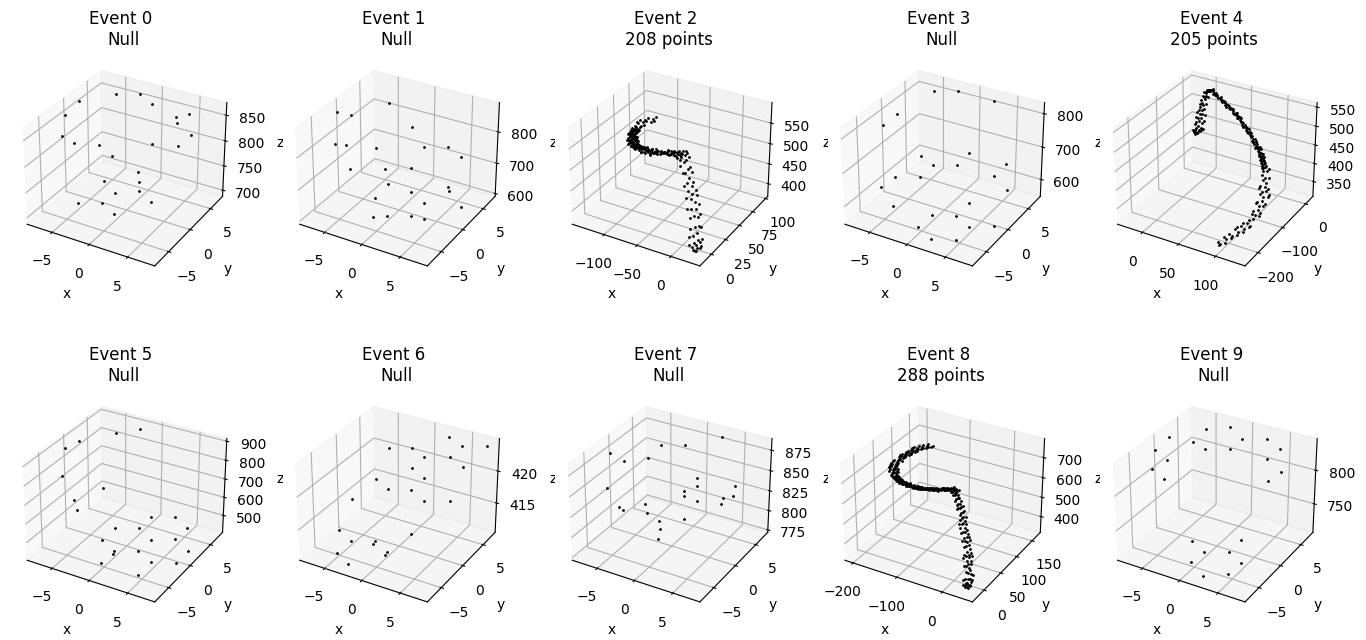

In [21]:
evlen_path = dir_name + ISOTOPE + '_exp_A' + str(amp_threshold) + '_ev_lens.npy'
data_path = dir_name + ISOTOPE + '_exp_A' + str(amp_threshold) + '_XYZAPE.npy'
nullInd_path = dir_name + ISOTOPE + '_exp_nullInd.npy'
plot_events(evlen_path, data_path, nullInd_path, amp_threshold, 1, 2)

The subplots below display no-null events. (mode = 2.)

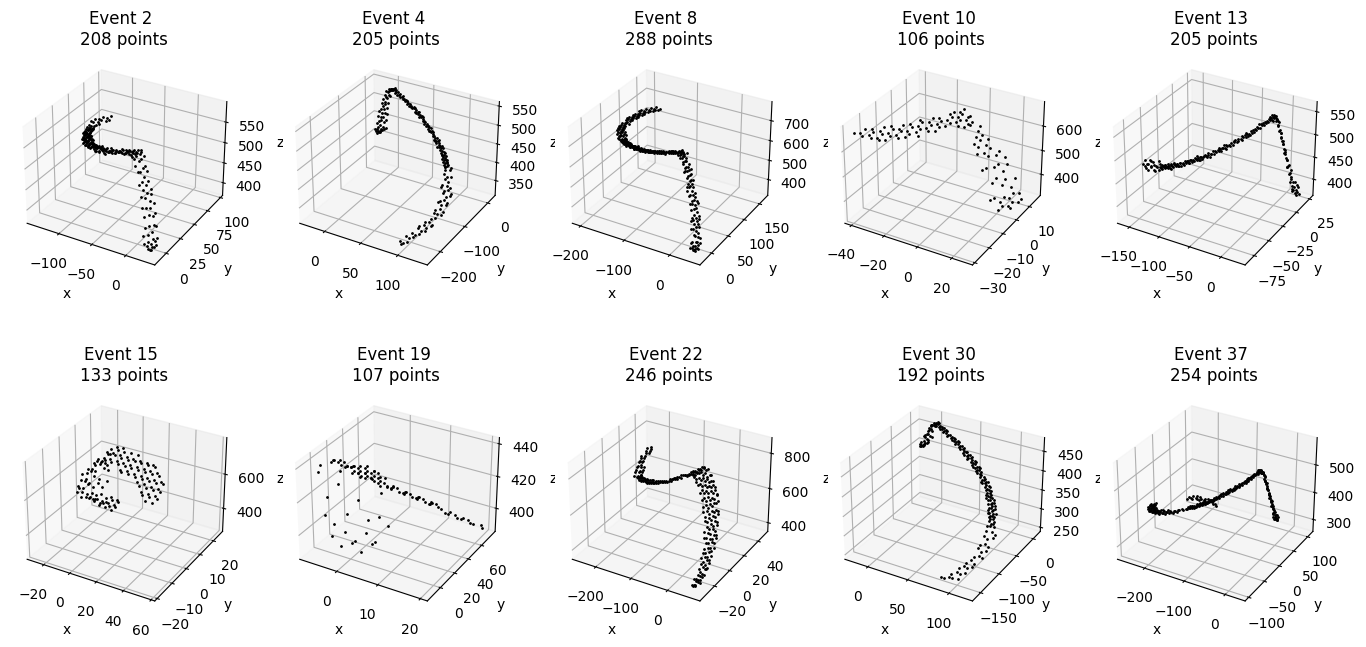

In [22]:
evlen_path = dir_name + ISOTOPE + '_exp_A' + str(amp_threshold) + '_noNull_ev_lens.npy'
data_path = dir_name + ISOTOPE + '_exp_A' + str(amp_threshold) + '_noNull_XYZAPE.npy'
nullInd_path = dir_name + ISOTOPE + '_exp_nullInd.npy'
plot_events(evlen_path, data_path, nullInd_path, amp_threshold, 2, 2)

## Sample 512 Points

In [23]:
evlen_path = dir_name + ISOTOPE + '_exp_A' + str(amp_threshold) + '_noNull_ev_lens.npy'
data_path = dir_name + ISOTOPE + '_exp_A' + str(amp_threshold) + '_noNull_XYZAPE.npy'
data_noNull = np.load(data_path)
num_of_event = len(data_noNull)
max_ev_len = 256 #len(data_noNull[0])
ev_lens = np.load(evlen_path)
data_sampled = np.zeros((num_of_event, max_ev_len, 6), float) #XYZAPE

for n in tqdm.tqdm(range(num_of_event)):
    ev_len = ev_lens[n]
    if ev_len >= sample_size:
        data_sampled[n,:sample_size,:] = data_noNull[n,:sample_size,:]
    else:
        data_sampled[n,:ev_len,:] = data_noNull[n,:ev_len,:]
        need = sample_size - ev_len
        random_points = np.random.choice(range(ev_len), need, replace= True if need > ev_len else False) 
        instant = ev_len
        for r in random_points:
            data_sampled[n,instant,:] = data_noNull[n,r,:] 
            instant += 1

data_path = dir_name + ISOTOPE + '_exp_A'+ str(amp_threshold) + '_noNull_size' + str(sample_size) + '_XYZAPE'
np.save(data_path, data_sampled)
print(data_sampled.shape)

100%|██████████| 3105/3105 [00:00<00:00, 13107.19it/s]


(3105, 256, 6)


## Normalize x, y, z, a

In [24]:
def rescale_feats(xs, ys, zs):
    RANGES = {
            'MIN_X': -270.0,
            'MAX_X': 270.0,
            'MIN_Y': -270.0,
            'MAX_Y': 270.0,
            'MIN_Z': -185.0,
            'MAX_Z': 1155.0
        }
    xs = (xs - RANGES['MIN_X']) / (RANGES['MAX_X'] - RANGES['MIN_X'])
    ys = (ys - RANGES['MIN_Y']) / (RANGES['MAX_Y'] - RANGES['MIN_Y'])
    zs = (zs - RANGES['MIN_Z']) / (RANGES['MAX_Z'] - RANGES['MIN_Z'])

    cloud = np.stack((xs, ys, zs), axis=-1)

    return cloud


def scale_file(file, idx):

    RANGES = {
            'MIN_X': -270.0,
            'MAX_X': 270.0,
            'MIN_Y': -270.0,
            'MAX_Y': 270.0,
            'MIN_Z': -185.0,
            'MAX_Z': 1155.0
        }
    
    if idx == 0:
        xs = (file[:, :, idx] - RANGES['MIN_X']) / (RANGES['MAX_X'] - RANGES['MIN_X'])
        return xs
    elif idx == 1:
        ys = (file[:, :, idx] - RANGES['MIN_Y']) / (RANGES['MAX_Y'] - RANGES['MIN_Y'])
        return ys
    elif idx == 2:
        zs = (file[:, :, idx] - RANGES['MIN_Z']) / (RANGES['MAX_Z'] - RANGES['MIN_Z'])
        return zs

In [25]:
data_path = dir_name + ISOTOPE + '_exp_A'+ str(amp_threshold) + '_noNull_size' + str(sample_size) + '_XYZAPE.npy'
data_sampled = np.load(data_path)
data_scaled = np.empty(data_sampled.shape)

data_scaled[:,:,3] = np.log10(data_sampled[:,:,3] + 1e-10)

for n in range(4):
    mean = np.mean(data_sampled[:,:,n])
    std = np.std(data_sampled[:,:,n])
    # data_scaled[:,:,n] = (data_sampled[:,:,n] - mean) / std
    if n == 3:
        amp_threshold_scaled = (amp_threshold - mean) / std
    else:
        data_scaled[:, :, n] = scale_file(data_sampled, n)

# data_scaled[:, :, 0], data_scaled[:, :, 1], data_scaled[:, :, 2] = rescale_feats(data_sampled[:, :, 0], data_sampled[:, :, 1], data_sampled[:, :, 2])

data_path = dir_name + ISOTOPE + '_exp_A'+ str(amp_threshold) + '_noNull_size' + str(sample_size) + '_scaled_XYZAPE'
np.save(data_path, data_scaled)

The subplots below display normalized no-null events. (mode = 2.)

(3105, 256, 6)

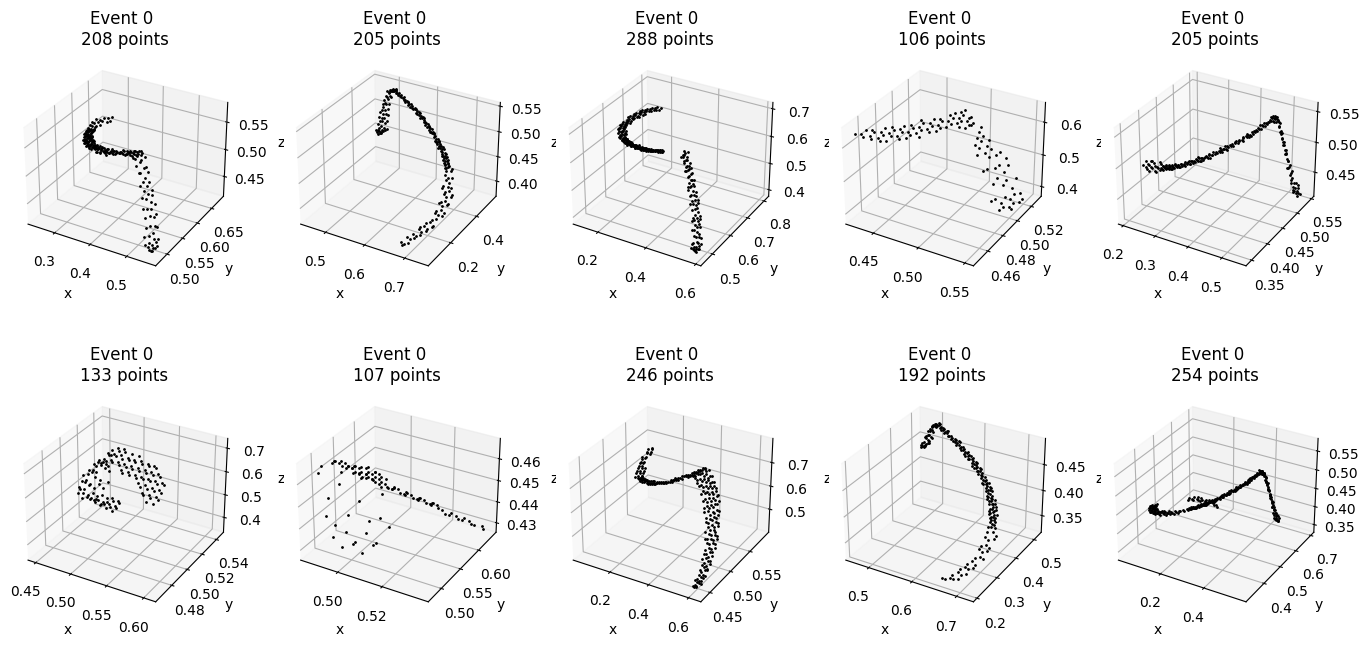

In [26]:
data_path = dir_name + ISOTOPE + '_exp_A'+ str(amp_threshold) + '_noNull_size' + str(sample_size) + '_scaled_XYZAPE.npy'
evlen_path = dir_name + ISOTOPE + '_exp_A'+ str(amp_threshold) + '_noNull_ev_lens.npy'
nullInd_path = dir_name + ISOTOPE + '_exp_nullInd.npy'
plot_events(evlen_path, data_path, nullInd_path, amp_threshold_scaled, 2, 2)
f = np.load(data_path)
f.shape

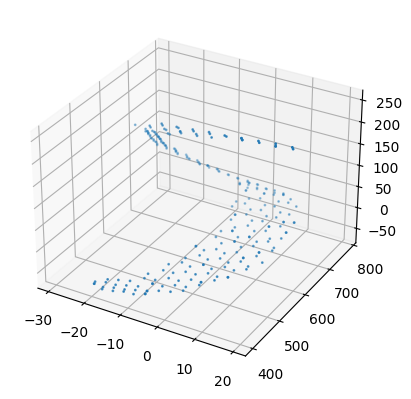

In [27]:
f = np.load(data_path)
def upscale(evt):

    RANGES = {
            'MIN_X': -270.0,
            'MAX_X': 270.0,
            'MIN_Y': -270.0,
            'MAX_Y': 270.0,
            'MIN_Z': -185.0,
            'MAX_Z': 1155.0
        }
    xs = evt[:, 0] * (RANGES['MAX_X'] - RANGES['MIN_X']) + RANGES['MIN_X']
    ys = evt[:, 1] * (RANGES['MAX_Y'] - RANGES['MIN_Y']) + RANGES['MIN_Y']
    zs = evt[:, 2] * (RANGES['MAX_Z'] - RANGES['MIN_Z']) + RANGES['MIN_Z']

    # cloud = np.stack((xs, ys, zs), axis=-1)

    return xs, ys, zs

xs, ys, zs = upscale(f[27])
# xs, ys, zs = upscale(np.stack((xs, ys, zs), axis=-1))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, zs, ys, s=1)
plt.show()